# Trip Planner using Langgraph

Environment Setup and Imports:

In [1]:
import os, getpass

os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter LANGSMITH_API_KEY: ")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [2]:
import os
import getpass
from typing import Annotated, TypedDict, List, Optional, Any
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq 

# 1. SETUP ENV & MODEL
if not os.environ.get("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your GROQ_API_KEY: ")

# Initialize ChatGroq
llm = ChatGroq(
    model="llama-3.1-70b-versatile", 
    temperature=0,
    api_key=os.environ["GROQ_API_KEY"]
)

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defining the `State` Schemas:

In [3]:
# 2. DEFINE STATES (The Blackboard)
class TripState(TypedDict):
    # Global state visible to the parent graph
    messages: Annotated[List[Any], add_messages]
    destination: str
    dates: str
    flight_options: Optional[List[str]] 
    selected_flight: Optional[str]      
    planned_activities: Optional[str]

class FlightState(TypedDict):
    # Local state for Flight Sub-graph
    destination: str
    dates: str
    raw_search_results: List[str] 
    final_options: List[str]

class ActivityState(TypedDict):
    # Local state for Activity Sub-graph
    destination: str
    selected_flight: str 
    itinerary: str

Building the Sub-Graphs:

In [4]:
# 3. BUILD SUB-GRAPHS (Module 4 Concept)

# Flight Sub-Graph 
def search_flights_api(destination: str):
    """Mock Tool"""
    return [
        f"Flight A: Arrive {destination} at 10:00 AM ($500)",
        f"Flight B: Arrive {destination} at 2:00 PM ($350)",
        f"Flight C: Arrive {destination} at 11:00 PM ($200)"
    ]

def flight_search_node(state: FlightState):
    results = search_flights_api(state['destination'])
    return {"raw_search_results": results}

def flight_curator_node(state: FlightState):
    return {"final_options": state["raw_search_results"]}

flight_builder = StateGraph(FlightState)
flight_builder.add_node("search_flights", flight_search_node)
flight_builder.add_node("curate_flights", flight_curator_node)
flight_builder.add_edge(START, "search_flights")
flight_builder.add_edge("search_flights", "curate_flights")
flight_builder.add_edge("curate_flights", END)
flight_graph = flight_builder.compile()

Defining `activity_planner` Sub-Graph:

In [5]:
# Activity Sub-Graph 
def activity_planning_node(state: ActivityState):
    # This node needs the 'selected_flight' from the shared state
    flight = state.get("selected_flight", "Unknown Flight")
    dest = state["destination"]
    
    # Simple logic to demonstrate dependency
    if "11:00 PM" in flight:
        plan = f"Day in {dest}: Late arrival. Check-in and sleep."
    else:
        plan = f"Day in {dest}: Drop bags, visit City Center, dinner."
    return {"itinerary": plan}

activity_builder = StateGraph(ActivityState)
activity_builder.add_node("plan_activities", activity_planning_node)
activity_builder.add_edge(START, "plan_activities")
activity_builder.add_edge("plan_activities", END)
activity_graph = activity_builder.compile()

Building the Parent Graph (The Controller), i.e, `call_flight_subgraph` and `call_activity_subgraph`

In [6]:
# 4. BUILD PARENT GRAPH (Hierarchical State)
def call_flight_subgraph(state: TripState):
    # Map Parent -> Child
    input_to_child = {"destination": state["destination"], "dates": state["dates"]}
    response = flight_graph.invoke(input_to_child)
    # Map Child -> Parent
    return {"flight_options": response["final_options"]}

def call_activity_subgraph(state: TripState):
    # Map Parent -> Child (Uses the UPDATED state after human intervention)
    input_to_child = {"destination": state["destination"], "selected_flight": state["selected_flight"]}
    response = activity_graph.invoke(input_to_child)
    # Map Child -> Parent
    return {"planned_activities": response["itinerary"]}

builder = StateGraph(TripState)
builder.add_node("flight_scout", call_flight_subgraph)
builder.add_node("activity_scout", call_activity_subgraph)

builder.add_edge(START, "flight_scout")
builder.add_edge("flight_scout", "activity_scout") 
builder.add_edge("activity_scout", END)

Compilation with Breakpoints:

In [7]:
# 5. COMPILE WITH CHECKPOINTER & INTERRUPT
checkpointer = MemorySaver()
graph = builder.compile(
    checkpointer=checkpointer, 
    interrupt_before=["activity_scout"] # Pause before running activities
)

Initial Execution:

In [8]:
# 6. INITIAL RUN
config = {"configurable": {"thread_id": "groq_trip_01"}}
initial_inputs = {"destination": "Paris", "dates": "June 15"}

print(f" Starting Trip Planner using Groq ({llm.model_name})...")
for event in graph.stream(initial_inputs, config):
    print(event)

print("\n Graph Paused. Ready for Human Input.")

 Starting Trip Planner using Groq (llama-3.1-70b-versatile)...
{'flight_scout': {'flight_options': ['Flight A: Arrive Paris at 10:00 AM ($500)', 'Flight B: Arrive Paris at 2:00 PM ($350)', 'Flight C: Arrive Paris at 11:00 PM ($200)']}}
{'__interrupt__': ()}

 Graph Paused. Ready for Human Input.


Human-in-the-Loop:

In [9]:
# 1. Inspect State (The Blackboard)
snapshot = graph.get_state(config)
existing_flights = snapshot.values["flight_options"]

print("Available Flights Found by Agent")
for i, flight in enumerate(existing_flights):
    print(f"[{i}] {flight}")

# 2. Human-in-the-Loop (Module 3)
choice_index = input("\n Enter the number (0, 1, or 2) of the flight you want: ")

try:
    selected_index = int(choice_index)
    user_selection = existing_flights[selected_index]
    print(f"\n You selected: {user_selection}")
except (ValueError, IndexError):
    print("Invalid input! Defaulting to Option 0.")
    user_selection = existing_flights[0]

# 3. Update State & Resume (Module 3 & 2)
print("Updating state...")
graph.update_state(config, {"selected_flight": user_selection})

print(" Resuming Graph to generate itinerary...")
# Passing None resumes execution from the breakpoint
for event in graph.stream(None, config):
    print(event)

# Final Output
final_state = graph.get_state(config).values
print("\n Final Itinerary:")
print(f"Flight: {final_state['selected_flight']}")
print(f"Plan: {final_state['planned_activities']}")

Available Flights Found by Agent
[0] Flight A: Arrive Paris at 10:00 AM ($500)
[1] Flight B: Arrive Paris at 2:00 PM ($350)
[2] Flight C: Arrive Paris at 11:00 PM ($200)

 You selected: Flight B: Arrive Paris at 2:00 PM ($350)
Updating state...
 Resuming Graph to generate itinerary...
{'activity_scout': {'planned_activities': 'Day in Paris: Drop bags, visit City Center, dinner.'}}

 Final Itinerary:
Flight: Flight B: Arrive Paris at 2:00 PM ($350)
Plan: Day in Paris: Drop bags, visit City Center, dinner.


Visualization:

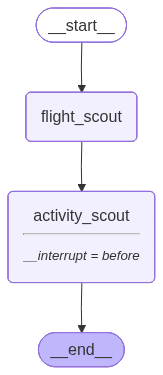

In [10]:
from IPython.display import Image, display

try:
    # Generates a PNG image of your graph structure
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # Fallback: specific system dependencies (like graphviz) might be missing.
    # If so, we print the text-based ASCII version.
    print("Could not render PNG. Printing ASCII version instead:")
    print(graph.get_graph().draw_ascii())

## Observation on LangSmith Traces

Here is the `activity_scout` stage:

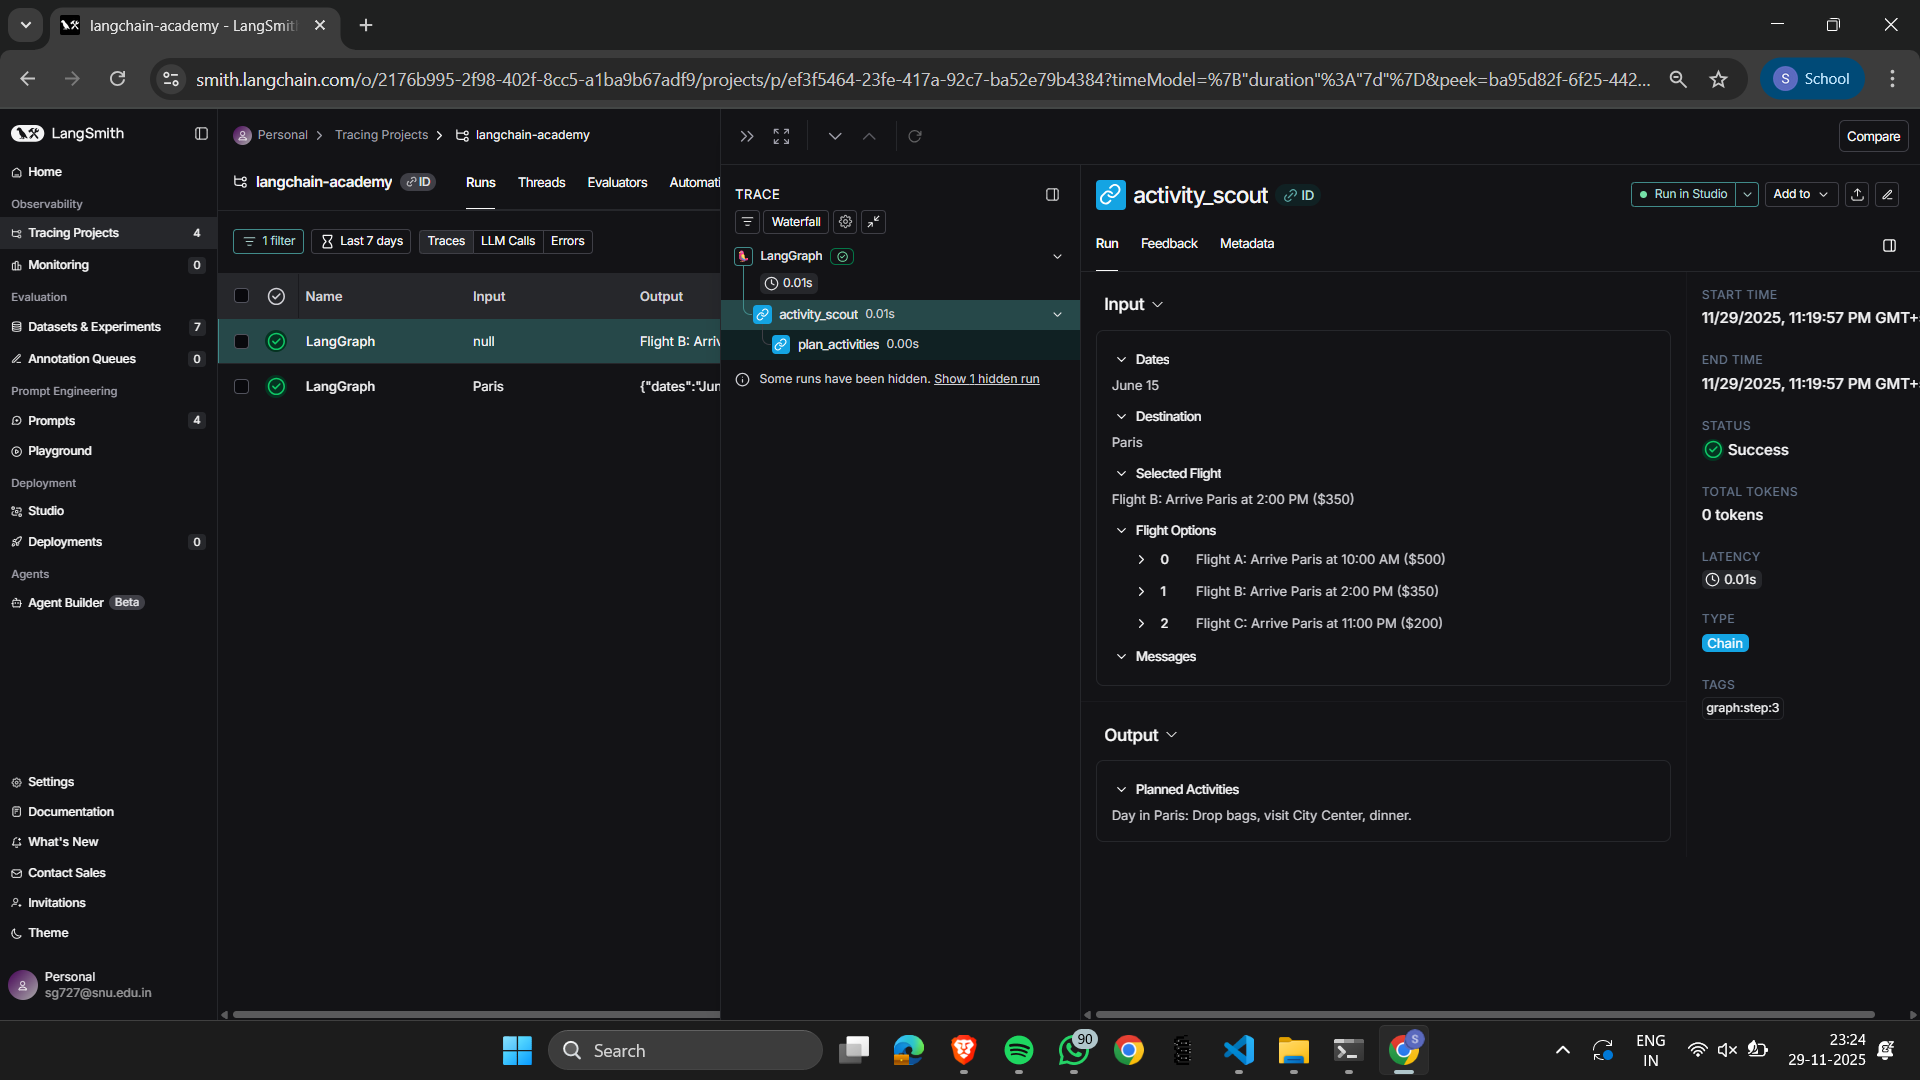

Here is the `plan_activities` output:

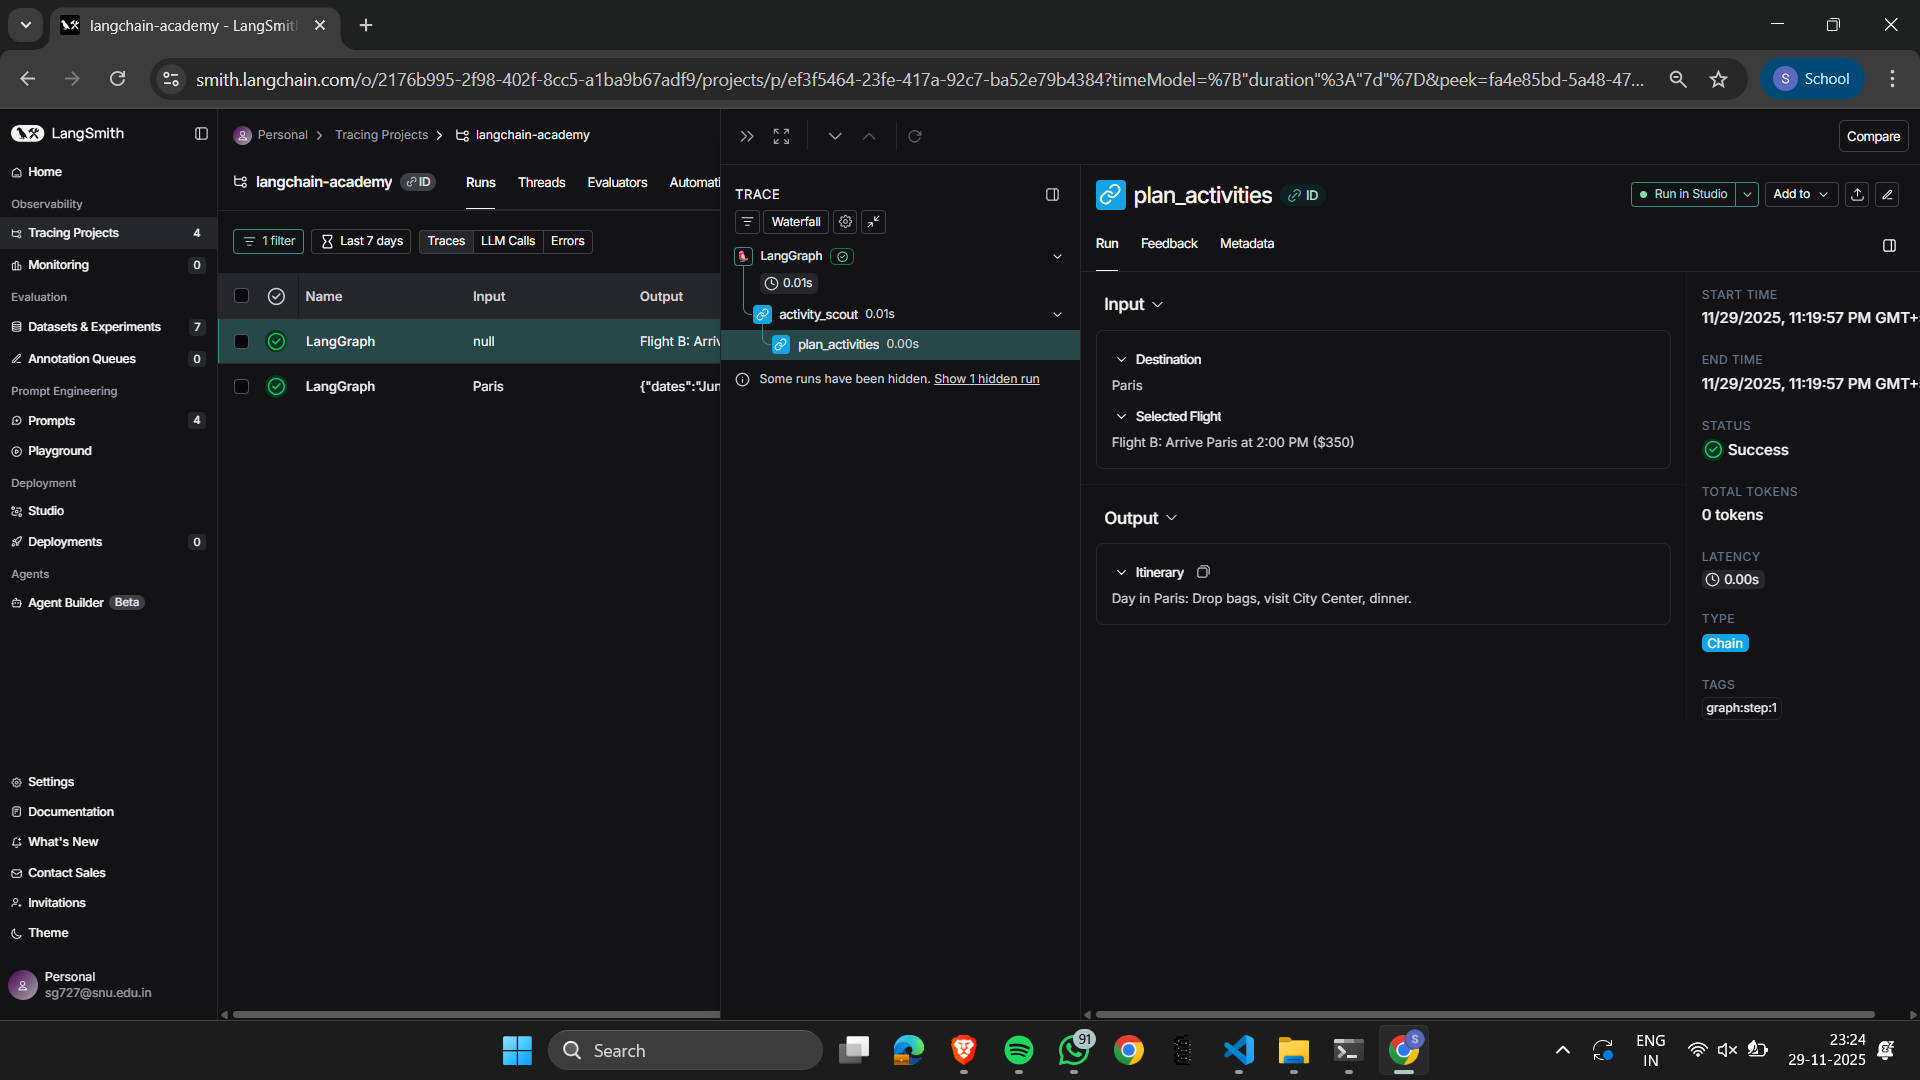

#### Here is the full dataflow of LangGraph:

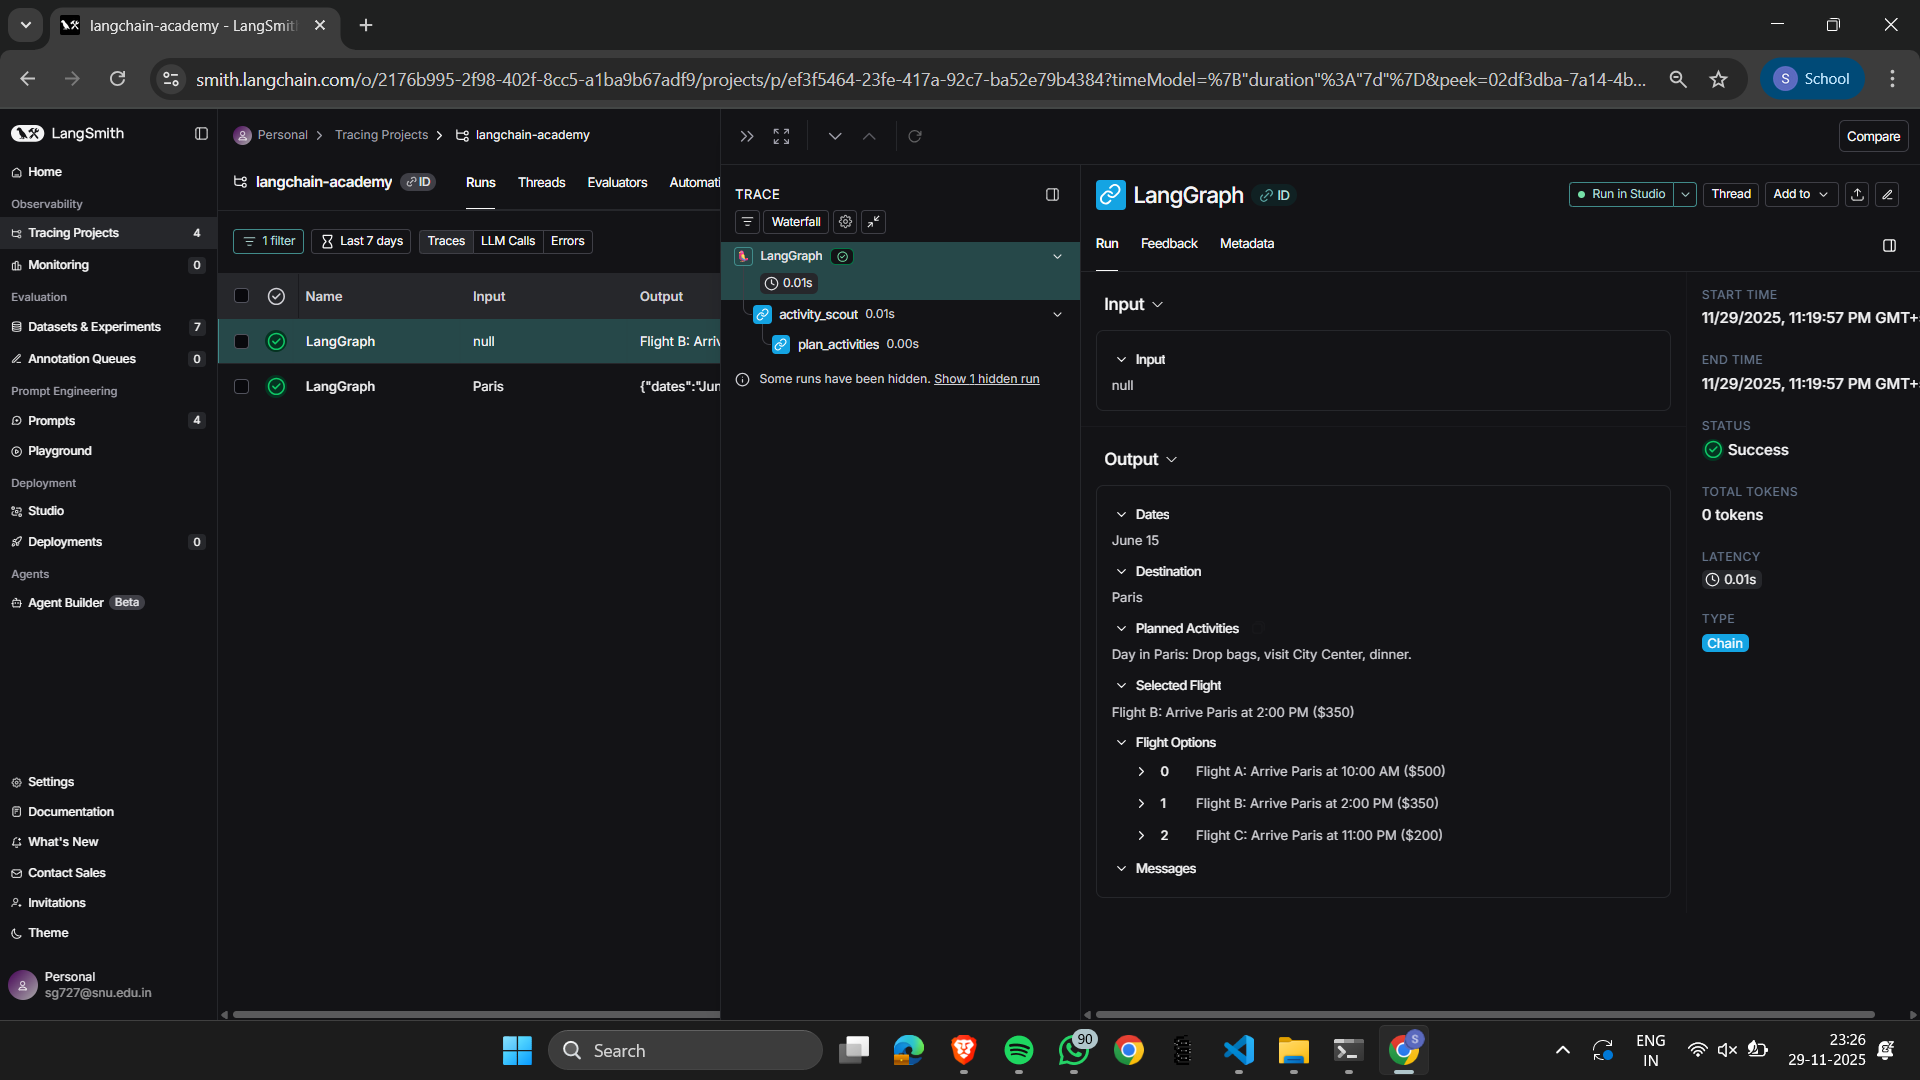